# 2022-12-07

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from collections import Counter

from typing import List

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split

import eli5

import nltk

from sklearn.metrics import accuracy_score, classification_report

from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

from nltk.tokenize import RegexpTokenizer

In [17]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /Users/dqmis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dqmis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/dqmis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dqmis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv("./data/imdb.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## First look

In [6]:
# let's look at 2 positive reviews

for value in df.loc[df["sentiment"] == "positive"].head(2).review.values:
    print(value)
    print()

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

In [7]:
# let's look at 2 positive reviews

for value in df.loc[df["sentiment"] == "negative"].head(2).review.values:
    print(value)
    print()

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.

This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the

As we noticed, that thre are some html tags within the text, we decided to clean reviews by removing the html tags:

In [8]:
def clean_html(text: str) -> str:
    return re.sub(r"<.*?>", "", text).strip()

text = "<p> Hello world! </p> <br/>"

print(clean_html(text))

Hello world!


In [9]:
df["review"] = df.review.apply(clean_html)

### Plotting word clouds

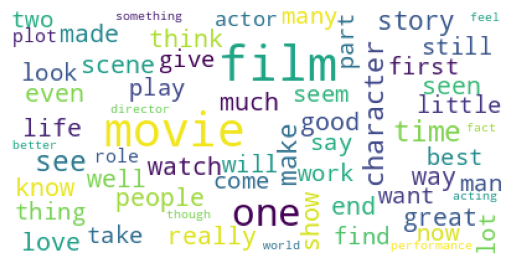

In [10]:
# looking at the cloud of postive reviews

postivie_df = df.loc[df["sentiment"] == "positive"]

all_reviews = " ".join(postivie_df["review"].values)

wordcloud = WordCloud().generate(all_reviews)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=60,max_font_size=40, relative_scaling=.5).generate(all_reviews)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

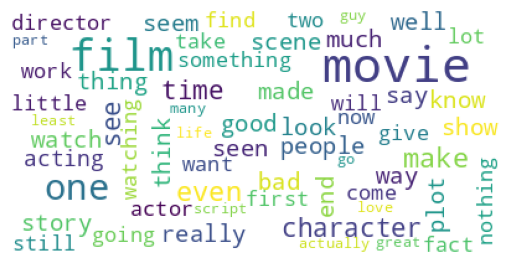

In [11]:
# looking at the cloud of negative reviews

negative_df = df.loc[df["sentiment"] == "negative"]

all_reviews = " ".join(negative_df["review"].values)

wordcloud = WordCloud().generate(all_reviews)

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=60,max_font_size=40, relative_scaling=.5).generate(all_reviews)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Count Vectorizer

In [51]:
cv = CountVectorizer()

corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]

result = cv.fit_transform(corpus).toarray()
print("dictionary: ", cv.get_feature_names_out())
print(result)

dictionary:  ['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [12]:
cv = CountVectorizer()

cv.fit(df["review"].values)
print("dictionary: ", cv.get_feature_names_out(), "size: ", len(cv.get_feature_names_out()))
result = cv.transform(["This movie is really great. It features talking cars!"]).toarray()
print(result)


dictionary:  ['00' '000' '00000000000' ... 'żmijewski' 'יגאל' 'כרמון'] size:  104083
[[0 0 0 ... 0 0 0]]


* There are a lot of language rubbish that does not add any meaning to the text - `a`, `the`, `on`, `under`. We remove stopwords to clean or data
* Words have different forms: `be` -> `was`, `were`; `begin` -> `began`. Use lemmatization to transform words into the basic form 
* We have also words with different contextual meanings that have the same stem. Sometimes (when working with count vectorizers) we want to form word into its stem: `United` -> `Unite` 

![](https://www.baeldung.com/wp-content/uploads/sites/4/2020/06/stemvslemma.png)

## Removing stopwords

In [23]:
tokenizer = RegexpTokenizer("\w+")

text = "Hello, my dear students!!!! This is a 33rd lecture, I hope you'll like it"

print(text.split())

print(tokenizer.tokenize(text))

['Hello,', 'my', 'dear', 'students!!!!', 'This', 'is', 'a', '33rd', 'lecture,', 'I', 'hope', "you'll", 'like', 'it']
['Hello', 'my', 'dear', 'students', 'This', 'is', 'a', '33rd', 'lecture', 'I', 'hope', 'you', 'll', 'like', 'it']


In [24]:
SnowballStemmer("english").stem(tokenizer.tokenize("United,")[0])

'unit'

In [26]:
tokenizer = RegexpTokenizer("\w+")

def remove_stop_words(text: str) -> str:
    text = text.lower()
    stop_words = set(stopwords.words("english"))
    words = tokenizer.tokenize(text)
    return " ".join([word for word in words if word not in stop_words])

In [27]:
df = pd.read_csv("./data/imdb.csv")

cv = CountVectorizer()

cv.fit(df["review"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

dictionary size:  101895


In [28]:
df = pd.read_csv("./data/imdb.csv")

df["review"] = df["review"].apply(remove_stop_words)

cv = CountVectorizer()

cv.fit(df["review"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

dictionary size:  101750


In [30]:
lemmatizer = WordNetLemmatizer()

In [31]:
tokenizer = RegexpTokenizer("\w+")
df = pd.read_csv("./data/imdb.csv")
df["review"] = df["review"].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in tokenizer.tokenize(x)]))

cv = CountVectorizer(stop_words=["english"])

cv.fit(df["review"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

dictionary size:  96173


In [35]:
stemmer = SnowballStemmer("english")

In [36]:
tokenizer = RegexpTokenizer("\w+")

df = pd.read_csv("./data/imdb.csv")
df["review"] = df["review"].apply(lambda x: " ".join([stemmer.stem(lemmatizer.lemmatize(i)) for i in tokenizer.tokenize(x)]))

cv = CountVectorizer(stop_words=["english"])

cv.fit(df["review"].values)
print("dictionary size: ", len(cv.get_feature_names_out()))

dictionary size:  70685


## Let's write a transformer!!

In [43]:
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        self._tokenizer = RegexpTokenizer("\w+")
        self._stemmer = SnowballStemmer("english")
        self._lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y = None):
        return self

    def _clean_html(self, text: str) -> str:
        return re.sub(r"<.*?>", "", text).strip()

    def _transform_text(self, text: str) -> str:
        text = self._clean_html(text)
        words = self._tokenizer.tokenize(text.lower())
        return " ".join([
            self._stemmer.stem(self._lemmatizer.lemmatize(word)) for word in words
        ])
    
    def transform(self, X: List[str], y = None) -> List[str]:
        return [self._transform_text(x) for x in X]

### Creating pipeline

In [44]:
pipeline = Pipeline([
    ("text_preprocessor", TextTransformer()),
    ("cv", CountVectorizer(stop_words=["english"])),
    ("model", LogisticRegression())
])

In [56]:
df = pd.read_csv("./data/imdb.csv")

df["label"] = df["sentiment"].apply(lambda x: int(x == "positive"))

df.groupby(by=["label"]).size()


label
0    25000
1    25000
dtype: int64

In [57]:
train_df, test_df = train_test_split(df)

In [58]:
pipeline.fit(train_df["review"].values, train_df["label"].values)

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('text_preprocessor', TextTransformer()),
                ('cv', CountVectorizer(stop_words=['english'])),
                ('model', LogisticRegression())])

In [66]:
y_true = test_df["label"].values

predictions = pipeline.predict(test_df["review"].values)

print("Accuracy: ", accuracy_score(y_true, predictions))
print(classification_report(y_true, predictions))

Accuracy:  0.88352
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      6273
           1       0.88      0.88      0.88      6227

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500



In [67]:
pipeline.predict_proba(["This movies was really slow and uninteresting. I fell asleep while wathching it"])

array([[0.93612822, 0.06387178]])

In [68]:
pipeline.predict_proba(["What an experience! This is the best cinema can offer"])

array([[0.43185558, 0.56814442]])

In [69]:
pipeline.predict_proba(["What a refreshing film i'll never forgett it!"])

array([[0.48198937, 0.51801063]])

In [70]:
pipeline.predict_proba(["Sitas filmas buvo pasibaisetinas. Uzmigau kai ji ziurejau"])

array([[0.43579916, 0.56420084]])

In [71]:
feature_names = pipeline.named_steps["cv"].get_feature_names_out()
feature_names

array(['00', '000', '00000000000', ..., 'þór', 'יגאל', 'כרמון'],
      dtype=object)

In [72]:
eli5.explain_weights(pipeline.named_steps["model"], top=50, feature_names=feature_names)

Weight?,Feature
+1.976,solid
+1.784,refresh
+1.690,subtl
+1.689,funniest
+1.644,outstand
+1.513,gem
+1.449,superb
+1.377,marvel
+1.332,pleasant
+1.295,unexpect
